In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import string

from os import path
from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
import nltk.sentiment

%matplotlib inline

/Users/seth/anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Part 0: Loading and cleaning the data

**First we need to load the emails into a dataframe.**

In [2]:
# Read Emails.csv into pandas
emails_dir = "hillary-clinton-emails"
emails_csv_filename = "Emails.csv"

emails_path = path.join(emails_dir, emails_csv_filename)

emails_df = pd.read_csv(emails_path)
len(emails_df)

7945

In [3]:
# Take a peek
emails_df.sample(5)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
7780,7781,C05776604,THE SPEECH,abedinh@state.gov,Huma@clintonemail.com,81.0,2010-12-02T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0111/DOC_0C0...,F-2014-20439,...,H; 'abedinh@state.gov',Huma Abedin <,NaN,"Thursday, December 2, 2010 7:02 PM",F-2014-20439,C05776604,08/31/2015,RELEASE IN PART,Ok. No problem.\nWe leave at 10:45. They will ...,UNCLASSIFIED U.S. Department of State Case No....
476,477,C05758741,ADAM PARKHOMENKO,Russorv@state.gov,H,80.0,2009-06-10T04:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/2_3_4/DOC_0C05...,F-2014-20439,...,'Russorv@state.gov'; 'JilotyLC@state.gov',H <hrod17@clintonemail.com>,NaN,"Wednesday, June 10, 2009 10:00 PM",F-2014-20439,C05758741,06/30/2015,RELEASE IN FULL,Ok.,UNCLASSIFIED U.S. Department of State Case No....
1970,1971,C05762562,FYI GIBBS EXCERPT FROM 6/30,H,"Mills, Cheryl D",32.0,2009-07-02T04:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/AddBacks/DOC_0...,F-2014-20439,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>",NaN,"Thursday, July 02, 2009 3:01 PM",F-2014-20439,C05762562,06/30/2015,RELEASE IN PART,Read traffic all the way down,UNCLASSIFIED U.S. Department of State Case No....
4915,4916,C05769180,THE SPEECH,H,"Sullivan, Jacob J",87.0,2010-01-20T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0059/DOC_0C0...,F-2014-20439,...,H,"Sullivan, Jacob J <SullivanJJ@state.gov>",NaN,"Wednesday, January 20, 2010 10:45 PM",F-2014-20439,C05769180,08/31/2015,RELEASE IN PART,little has changed in substance or language.\n...,UNCLASSIFIED U.S. Department of State Case No....
2789,2790,C05764484,SECRETARY'S EMAIL,H,"Mills, Cheryl D",32.0,2009-09-05T04:00:00+00:00,2015-07-31T04:00:00+00:00,DOCUMENTS/HRCEmail_JulyWeb/Web_036/DOC_0C05764...,F-2014-20439,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Jiloty, Lauren C","Saturday, September 05, 2009 5:12 PM",F-2014-20439,C05764484,07/31/2015,RELEASE IN PART,K - will give to him directly,UNCLASSIFIED U.S. Department of State Case No....


**We want to create our wordcloud from the column(s) that contain(s) the full text of the emails. From the schema, we know that the email subject should be in ExtractedSubject and email text should be in ExtractedBodyText. But we should make sure these fields are filled in!**

In [4]:
# Which columns of the dataframe contain the text we want for our wordcloud?
#I found:
#- ExtractedSubject
#- ExtractedBodyText
#- RawText

# check these columns to see if they're actually filled in and make sense
emails_df.isnull().sum()

Id                                 0
DocNumber                          0
MetadataSubject                  296
MetadataTo                       255
MetadataFrom                     157
SenderPersonId                   157
MetadataDateSent                 132
MetadataDateReleased               0
MetadataPdfLink                    0
MetadataCaseNumber                 0
MetadataDocumentClass              0
ExtractedSubject                1685
ExtractedTo                     4657
ExtractedFrom                   1253
ExtractedCc                     5305
ExtractedDateSent               1317
ExtractedCaseNumber                1
ExtractedDocNumber                 1
ExtractedDateReleased              1
ExtractedReleaseInPartOrFull       0
ExtractedBodyText               1203
RawText                            0
dtype: int64

**Most rows have non-null ExtractedSubject and ExtractedBodyText, so we decided arbitrarily to drop all the emails that are missing these fields.**

In [5]:
# In-place!
emails_df.dropna(subset=['ExtractedSubject', 'ExtractedBodyText'], inplace=True)
len(emails_df)

5425

# Part 1: Generating wordclouds!

**We'll generate a wordcloud using the concatenated text of the entire email corpus.**

(-0.5, 399.5, 199.5, -0.5)

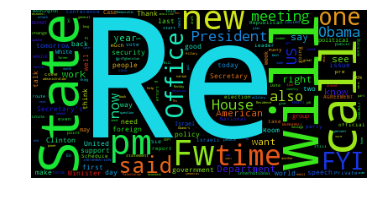

In [6]:
#Concatenate all raw text
concatenated_body_text = ' '.join(emails_df['ExtractedSubject'] + ' ' + emails_df['ExtractedBodyText'])
len(concatenated_body_text)

# Generate a word cloud image
wordcloud = WordCloud().generate(concatenated_body_text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")

**The wordcloud library helpfully removed common english stopwords, but we still have some boring terms like 'RE' and 'FW' in our cloud!**

**We can improve the results by doing some pre-processing:**
- tokenization
- stopword removal (including email terms)
- lemmatization
- stemming (maybe?)
- remove punctuation & single char tokens

In [7]:
import nltk
from nltk.corpus import stopwords
#NOTE to team you should run nltk.download() but maybe outside the notebook

In [8]:
#Takes a few seconds to run:
tokenized = nltk.word_tokenize(concatenated_body_text)

In [9]:
tokenized[:10]

['Re',
 ':',
 'Chris',
 'Stevens',
 'Thx',
 'Meet',
 'The',
 'Right',
 'Wing',
 'Extremist']

**Let's remove some more stopwords**

In [10]:
# Define annoying email terms as stopwords
email_stopwords = nltk.corpus.stopwords.words('english')
additional_stopwords = ['subject', 'date', 're', 'cc', 'bcc', 'fwd', 'fw', 'sent', 'mr', 'mrs']
email_stopwords.extend(additional_stopwords)

In [11]:
tokens_without_stopwords = [t.lower() for t in tokenized if t.lower() not in email_stopwords]

**Lemmatization - we use the WordnetLemmatizer to group inflected forms of a word**

In [12]:
lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [lemmatizer.lemmatize(t) for t in tokens_without_stopwords]

**Stemming - we can use the porter stemmer to normalize our text**

In [13]:
porter = nltk.PorterStemmer()
processed_tokens = [porter.stem(t) for t in lemmatized_tokens]

**Remove punctuation & single character token**

In [14]:
def remove_punctuation(token):
    for c in string.punctuation:
        token = token.replace(c, "")
    
    return token

In [15]:
processed_tokens = [token for token in processed_tokens if len(token) > 1]
processed_tokens = [remove_punctuation(token) for token in processed_tokens]

In [16]:
processed_tokens[:10]

['chri',
 'steven',
 'thx',
 'meet',
 'right',
 'wing',
 'extremist',
 'behind',
 'antimuslim',
 'film']

**Our NLTK pipeline (fully defined below) consists of tokenization, lower-case conversion, lemmatization and punctuation/single char removal.**

In [17]:
# All processing at once. We don't apply stemming on emails, since it would destroy most country names
def process_text(text):
    tokens = nltk.word_tokenize(text)
    lowered = (t.lower() for t in tokens)
    processed = (lemmatizer.lemmatize(t) for t in lowered if t not in email_stopwords)
    processed = (remove_punctuation(t) for t in processed)
    processed = (t for t in processed if len(t) > 1)
            
    return list(processed)

(-0.5, 399.5, 199.5, -0.5)

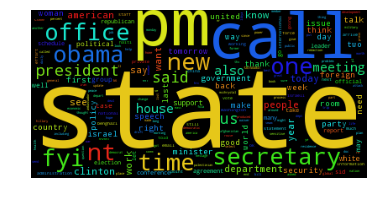

In [18]:
wc2_processed_tokens = process_text(concatenated_body_text)
wordcloud2 = WordCloud().generate(" ".join(wc2_processed_tokens))

plt.imshow(wordcloud2)
plt.axis("off")

**The second wordcloud looks a bit better thanks to the additional processing. Some conclusions:**
- (+) we were able to remove some of the mundane email terms from the text
- (~) lemmatization seemed more useful than stemming for generating a readable wordcloud.
- (-) removing words is sort of an iterative process as each time we generate the wordcloud we see new frequent words that we'd prefer to exclude!

# 2. World country mentions

**We use pycountry to find references in the emails to various countries**

In [19]:
import pycountry

In [20]:
countries = {country: 0 for country in pycountry.countries}

**First we go through all of the tokens and look for any mentions of countries**

In [21]:
bad_country_tokens = set()
concatenated_body_text = " ".join(str(email) for email in emails_df["ExtractedBodyText"])

for token in process_text(concatenated_body_text):
    if token not in bad_country_tokens:
        try:
            country = pycountry.countries.lookup(token)
            countries[country] += 1
        except LookupError:
            bad_country_tokens.add(token)

In [22]:
country_df = pd.DataFrame.from_dict({country.name: occurence for (country, occurence) in countries.items()}, orient="index")
country_df.columns = ["Occurences"]

In [23]:
country_df.sort_values(by="Occurences", ascending=False).head(10)

,Occurences
Saint Pierre and Miquelon,1326
United States,743
Israel,405
China,262
Afghanistan,254
"Venezuela, Bolivarian Republic of",220
Réunion,195
Haiti,178
Mauritania,174
Libya,135


In [24]:
print(pycountry.countries.lookup("PM").name)
print(pycountry.countries.lookup("AM").name)

Saint Pierre and Miquelon
Armenia


**Saint Pierre and Miquelon refers to "PM". "AM" was already in the stop-words, that's why we don't have problems with Armenia. We could start again with "pm" as a stopword, but Saint Pierre and Miquelon is very likely not to appear in any email.**

In [25]:
country_df.loc["Saint Pierre and Miquelon"] = 0
country_df.sort_values(by="Occurences", ascending=False).head(10)

,Occurences
United States,743
Israel,405
China,262
Afghanistan,254
"Venezuela, Bolivarian Republic of",220
Réunion,195
Haiti,178
Mauritania,174
Libya,135
Angola,132


In [26]:
vader = nltk.sentiment.vader.SentimentIntensityAnalyzer()

In [27]:
vader.polarity_scores("I love you")

{'compound': 0.6369, 'neg': 0.0, 'neu': 0.192, 'pos': 0.808}

In [28]:
vader.polarity_scores("I hate you")

{'compound': -0.5719, 'neg': 0.787, 'neu': 0.213, 'pos': 0.0}

In [29]:
email_stopwords.append("pm")

In [30]:
import os.path
import pickle

# Create cache folder
CACHE_DIR = "cache"
CACHE_PATH = os.path.join(CACHE_DIR, "country_sentiment_df.bak")

if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)

In [31]:
country_sentiment_list = []

# !! If not in the cache, takes ~10 min to run
if os.path.isfile(CACHE_PATH):
    with open(CACHE_PATH, 'rb') as handle:
        country_sentiment_df = pickle.load(handle)

else:
    for (index, email) in emails_df.iterrows():
        text = email["ExtractedBodyText"]
        words = process_text(str(text))

        for word in words:
            if word not in bad_country_tokens:
                country = pycountry.countries.lookup(word)
                sentiment = vader.polarity_scores(text)["compound"]
                country_sentiment_list.append([country.name, sentiment])
                break

    country_sentiment_df = pd.DataFrame(country_sentiment_list, columns=["Country", "Sentiment"])
    
    with open(CACHE_PATH, 'wb') as handle:
        pickle.dump(country_sentiment_df, handle)

In [32]:
sentiment_by_country = country_sentiment_df.groupby("Country")


sentiment_occurence_df = sentiment_by_country.count().join(sentiment_by_country.mean(), lsuffix='_left')
sentiment_occurence_df.columns = ["Frequency", "Sentiment"]

**First, a full & difficult to read plot of sentiment towards countries. Then, we only show countries with most positive / most negative sentiment. We can see that the emails globally have a positive sentiment.**

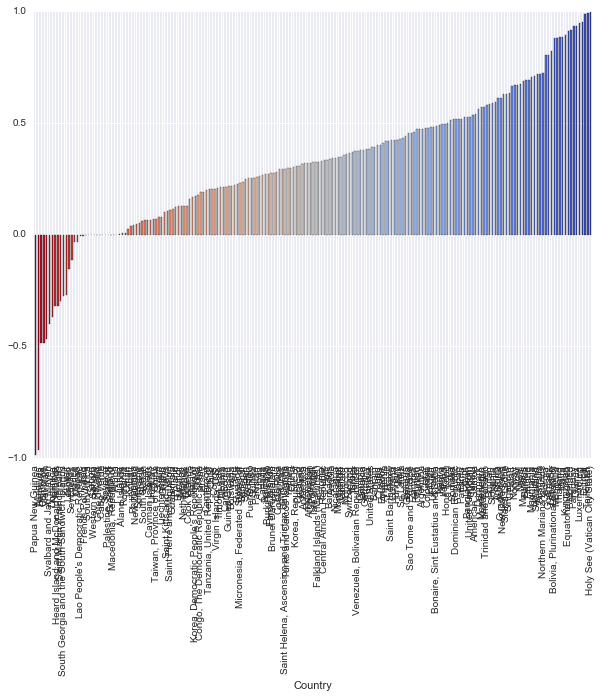

In [33]:
palette = sns.color_palette("coolwarm_r", n_colors=len(sentiment_occurence_df))
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
sentiment_occurence_df["Sentiment"].sort_values().plot(kind="bar", color=palette)

**Below is a plot of the countries towards which Hillary & co. expressed the most negative sentiment**

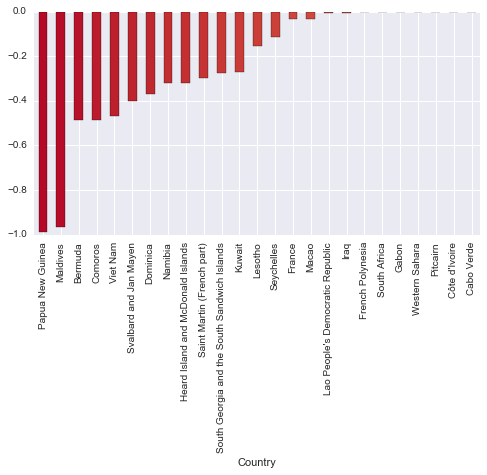

In [34]:
matplotlib.rcParams['figure.figsize'] = (8, 4)

# Most negative sentiment
sentiment_occurence_df["Sentiment"].sort_values().head(25).plot(kind="bar", color=palette)

**Similarly, here is a plot of the countries towards which Hillary & co. expressed the most positive sentiment**

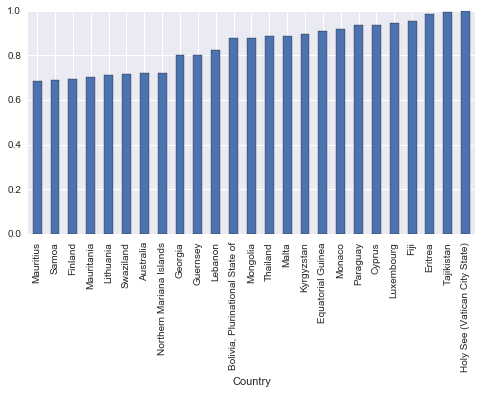

In [35]:
# Most positive sentiment
sentiment_occurence_df["Sentiment"].sort_values().tail(25).plot(kind="bar")

**NOTE: There are some surprising countries at the top of the sentiment list!**

# 3. Topic modeling

In [36]:
import gensim.models.ldamodel as ldamodel
import gensim.corpora as corpora

/Users/seth/anaconda/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


**For this task we use the full emails (including subject), process the text with our NLTK piepline, then create LDA modes with varying numbers of topics**

In [37]:
texts = [process_text(str(email)) for email in emails_df['ExtractedSubject'] + " " + emails_df["ExtractedBodyText"]]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [38]:
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10)

In [39]:
def pretty_print_topics(lda):
    for topics in lda.show_topics(num_topics=20, num_words=8, formatted=False):
        print([topic[0] for topic in topics[1]])
        

In [40]:
# !! Takes a few minutes
models = dict()
for topics_count in range(5, 50, 10):
    print("{} topics".format(topics_count))
    models[topics_count] = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=topics_count)
    pretty_print_topics(models[topics_count])
    print()

5 topics
['state', 'would', 'one', 'party', 'call', 'fyi', 'american', 'israel']
['state', 'new', 'obama', 'fyi', 'nt', 'would', 'one', 'woman']
['obama', 'time', 'nt', 'would', 'said', 'see', 'call', 'president']
['call', 'secretary', 'office', 'state', 'meeting', 'department', 'time', 'room']
['nt', 'would', 'new', 'american', 'right', 'one', 'know', 'said']

15 topics
['state', 'obama', 'american', 'would', 'time', 'president', 'one', 'clinton']
['call', 'get', 'back', 'also', 'talk', 'nt', 'ok', 'email']
['state', 'woman', '14', 'party', 'would', 'issue', 'nt', 'one']
['call', 'let', 'think', 'know', 'right', 'one', 'see', 'thx']
['draft', 'speech', 'office', 'secretary', 'thanks', 'daniel', 'call', 'state']
['state', 'nt', 'us', 'congress', 'party', 'american', 'israel', 'obama']
['israel', 'obama', 'say', 'republican', 'nt', 'would', 'new', 'year']
['call', 'palestinian', 'pls', 'arab', 'list', 'israel', 'ok', 'israeli']
['secretary', 'office', 'meeting', 'state', 'room', 'depart

**It's very difficult to tell without more knowledge of the email contents, but it looks like 45 topics gives the most meaningful results. There are some pretty stable topics across the different iterations, for example Israeli-Arab-Palestinian relations.**